In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset, Dataset,random_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from torchvision import models
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report


import os
from PIL import Image, ImageEnhance, ImageFilter
from tqdm import tqdm
from torchvision import transforms,datasets
import cv2

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


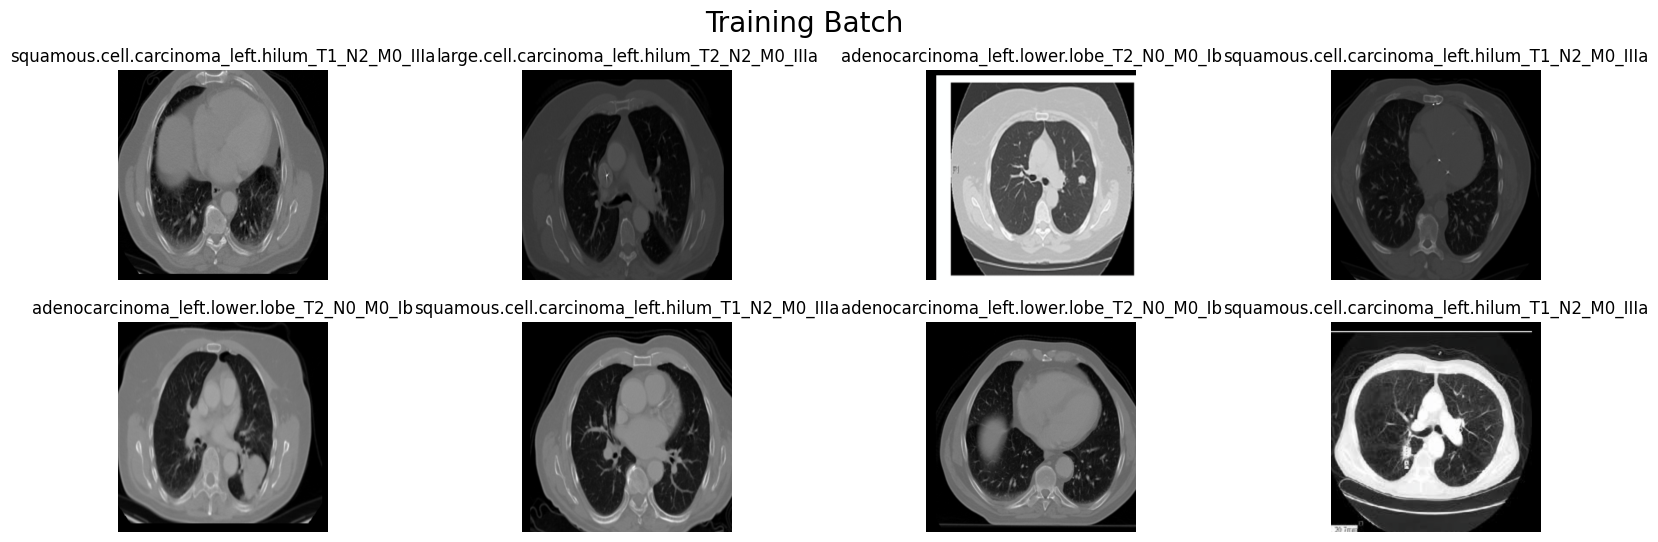

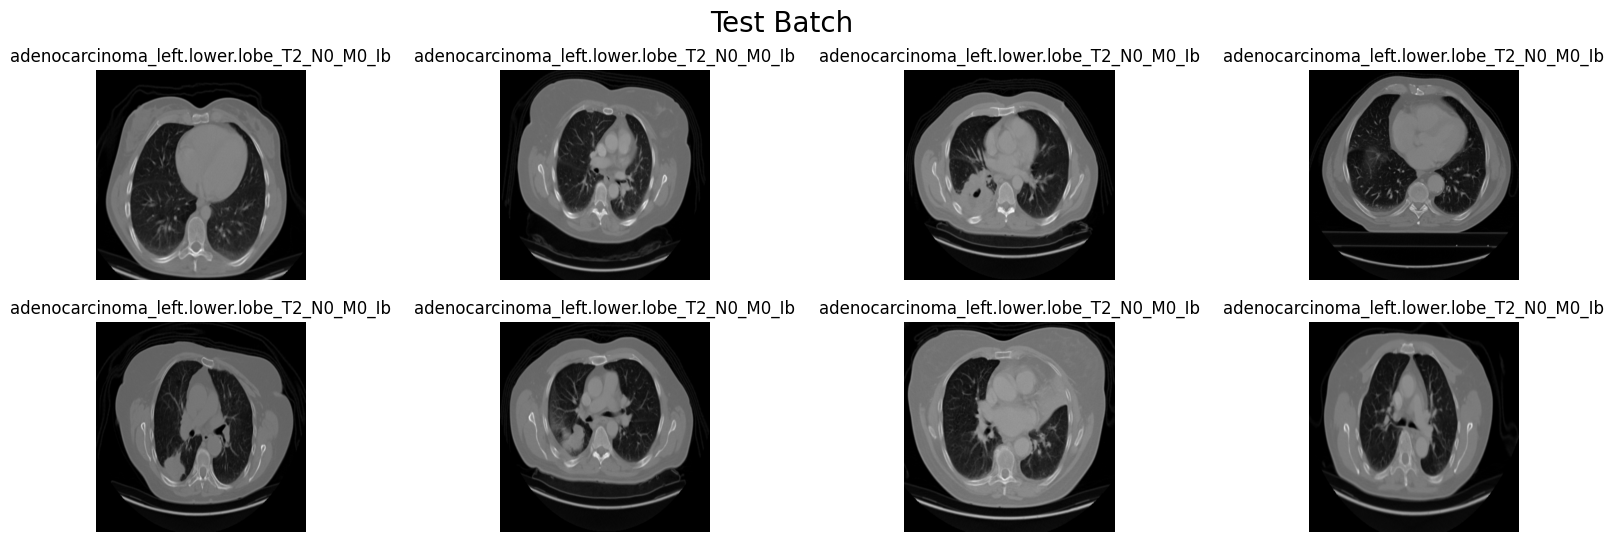

In [16]:
# Function to unnormalize and convert a tensor to a numpy array
def imshow(img, mean, std):
    img = img.numpy().transpose((1, 2, 0))  # Convert to HWC format
    img = img * std + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip the pixel values
    plt.imshow(img)

# Define transformations for the training and test sets
train_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomAffine(degrees=(0),
                            translate=(0.05, 0.05),
                            scale=(1.0, 1.0),
                            shear=0),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='C:/Users/ASUS/NextgenAI/Projects/Data/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='C:/Users/ASUS/NextgenAI/Projects/Data/test', transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get one batch from the train and test DataLoader
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Classes in the dataset
classes = train_dataset.classes
print(classes)

# Mean and Std for unnormalizing the images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Plotting the training images
plt.figure(figsize=(20, 6))
plt.suptitle('Training Batch', fontsize=20)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(train_images[i], mean, std)
    plt.title(classes[train_labels[i].item()])
    plt.axis('off')

plt.show()

# Plotting the test images
plt.figure(figsize=(20, 6))
plt.suptitle('Test Batch', fontsize=20)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(test_images[i], mean, std)
    plt.title(classes[test_labels[i].item()])
    plt.axis('off')

plt.show()

In [3]:
class CustomResNet(nn.Module):
    def __init__(self, num_class=5, h_dims=[]):
        super(CustomResNet, self).__init__()

        self.resnet = models.resnet50(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = True

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity() 

        self.class_classifier = self._create_classifier(in_features, h_dims, num_class)

    def _create_classifier(self, in_features, h_dims, num_classes):
        layers = []
        for hdim in h_dims:
            layers.append(nn.Linear(in_features, hdim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.30))
            in_features = hdim
        layers.append(nn.Linear(in_features, num_classes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)  
        class_output = self.class_classifier(x)
        return class_output

In [4]:

# debuging model
dummy_input = torch.zeros(32, *(3,256,256))
model = CustomResNet(num_class = 4,h_dims=[256, 128])


c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class_out = model(dummy_input)
class_out.shape

tensor([[-0.0675, -0.0053,  0.0955,  0.0072],
        [-0.0815, -0.0332,  0.0282,  0.0300],
        [-0.1711, -0.1602,  0.0456, -0.0896],
        [-0.1378,  0.0086, -0.0028,  0.0401],
        [-0.1414,  0.0448,  0.0793, -0.0236],
        [-0.0297, -0.1018,  0.0592, -0.0357],
        [-0.1016,  0.0340,  0.0115, -0.0033],
        [-0.0159, -0.0270,  0.0602, -0.0394],
        [-0.0674,  0.0031,  0.1342,  0.0102],
        [-0.1151, -0.0852, -0.0138, -0.1178],
        [-0.0955, -0.0721,  0.0143, -0.0247],
        [-0.1862,  0.0154, -0.0210,  0.0646],
        [-0.0363, -0.0594,  0.0524, -0.0991],
        [-0.0867, -0.0265,  0.0297, -0.0273],
        [-0.0979,  0.0084,  0.0424, -0.0046],
        [-0.1610,  0.0533,  0.0653, -0.0198],
        [-0.1316, -0.1082, -0.0171,  0.0145],
        [-0.1463,  0.0671,  0.0053,  0.0146],
        [-0.1294, -0.0380,  0.0388, -0.0628],
        [-0.0515, -0.0157, -0.0449, -0.0987],
        [-0.1097, -0.0227,  0.0018,  0.0843],
        [-0.0470,  0.0248,  0.0497

In [7]:
best_score = 0.0
def train(model, optimizer, train_loader, test_loader, epochs=10, beta=2, checkpoint_path=None, device='cpu'):
    global best_score
    model = model.to(device)
    print("Training on", device)

    for epoch in range(epochs):
        model.train()
        
        # Define the scheduler and loss function
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        cross_entropy_loss = nn.CrossEntropyLoss()

        train_bar = tqdm(train_loader, desc=f'----Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)
            loss = cross_entropy_loss(output, target)

            loss.backward()
            optimizer.step()

            train_bar.set_postfix(loss=loss.item())

        model.eval()
        
        scheduler.step()

        correct = 0
        test_loss = 0

        all_preds, all_targets = [], []

        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Testing Epoch [{epoch+1}/{epochs}]", unit='batch')

            for data, target in test_bar:
                data, target = data.to(device), target.to(device)

                output = model(data)
                test_loss += cross_entropy_loss(output, target).item()

                preds = output.argmax(dim=1, keepdim=True)
                correct += preds.eq(target.view_as(preds)).sum().item()

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

            test_loss /= len(test_loader.dataset)
            accuracy = correct / len(test_loader.dataset)
            fbeta = fbeta_score(all_targets, all_preds, beta=beta, average='weighted')

            print(f'Test loss: {test_loss:.4f} || Accuracy: {accuracy:.4f} || F1: {fbeta:.4f} || BEST_SCORE : {best_score}')

            if fbeta > best_score:
                best_score = fbeta
                print(f'Has Checkpoint path at {checkpoint_path}\nBest model saved with F1 Score: {fbeta:.4f} at epoch[{epoch+1}]⭐')
                if checkpoint_path:
                    torch.save(model.state_dict(), checkpoint_path)
            print(" ")
                    


In [8]:
model = CustomResNet(num_class= 4,h_dims=[1024,512,512,256])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001 , weight_decay=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      beta=2,
      checkpoint_path="C:/Users/ASUS/NextgenAI/Projects/ABCC.pth",
      device=device)

c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on cuda


Testing Epoch [1/50]: 100%|██████████| 40/40 [00:07<00:00,  5.36batch/s]


Test loss: 0.1080 || Accuracy: 0.5524 || F1: 0.4793 || BEST_SCORE : 0.0
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.4793 at epoch[1]⭐
 


Testing Epoch [2/50]: 100%|██████████| 40/40 [00:05<00:00,  7.44batch/s]


Test loss: 0.1103 || Accuracy: 0.6000 || F1: 0.5487 || BEST_SCORE : 0.47926212386142697
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.5487 at epoch[2]⭐
 


Testing Epoch [3/50]: 100%|██████████| 40/40 [00:05<00:00,  7.42batch/s]


Test loss: 0.1029 || Accuracy: 0.5524 || F1: 0.4837 || BEST_SCORE : 0.5486798995254342
 


Testing Epoch [4/50]: 100%|██████████| 40/40 [00:05<00:00,  6.88batch/s]


Test loss: 0.0912 || Accuracy: 0.6381 || F1: 0.6172 || BEST_SCORE : 0.5486798995254342
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.6172 at epoch[4]⭐
 


Testing Epoch [5/50]: 100%|██████████| 40/40 [00:05<00:00,  7.48batch/s]


Test loss: 0.0977 || Accuracy: 0.6508 || F1: 0.6382 || BEST_SCORE : 0.617242074676081
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.6382 at epoch[5]⭐
 


Testing Epoch [6/50]: 100%|██████████| 40/40 [00:05<00:00,  7.40batch/s]


Test loss: 0.0536 || Accuracy: 0.8349 || F1: 0.8295 || BEST_SCORE : 0.6382499368984086
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.8295 at epoch[6]⭐
 


Testing Epoch [7/50]: 100%|██████████| 40/40 [00:05<00:00,  7.46batch/s]


Test loss: 0.0771 || Accuracy: 0.7968 || F1: 0.7928 || BEST_SCORE : 0.8295216385208334
 


Testing Epoch [8/50]: 100%|██████████| 40/40 [00:05<00:00,  6.85batch/s]


Test loss: 0.0345 || Accuracy: 0.8952 || F1: 0.8948 || BEST_SCORE : 0.8295216385208334
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.8948 at epoch[8]⭐
 


Testing Epoch [9/50]: 100%|██████████| 40/40 [00:05<00:00,  7.32batch/s]


Test loss: 0.0591 || Accuracy: 0.8190 || F1: 0.8180 || BEST_SCORE : 0.8948281393228508
 


Testing Epoch [10/50]: 100%|██████████| 40/40 [00:05<00:00,  6.82batch/s]


Test loss: 0.0575 || Accuracy: 0.8286 || F1: 0.8243 || BEST_SCORE : 0.8948281393228508
 


Testing Epoch [11/50]: 100%|██████████| 40/40 [00:05<00:00,  7.20batch/s]


Test loss: 0.0423 || Accuracy: 0.8730 || F1: 0.8708 || BEST_SCORE : 0.8948281393228508
 


Testing Epoch [12/50]: 100%|██████████| 40/40 [00:05<00:00,  7.36batch/s]


Test loss: 0.0660 || Accuracy: 0.8698 || F1: 0.8673 || BEST_SCORE : 0.8948281393228508
 


Testing Epoch [13/50]: 100%|██████████| 40/40 [00:05<00:00,  7.40batch/s]


Test loss: 0.0378 || Accuracy: 0.9206 || F1: 0.9206 || BEST_SCORE : 0.8948281393228508
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.9206 at epoch[13]⭐
 


Testing Epoch [14/50]: 100%|██████████| 40/40 [00:05<00:00,  6.80batch/s]


Test loss: 0.0372 || Accuracy: 0.9206 || F1: 0.9202 || BEST_SCORE : 0.920640212224582
 


Testing Epoch [15/50]: 100%|██████████| 40/40 [00:05<00:00,  7.21batch/s]


Test loss: 0.0791 || Accuracy: 0.8000 || F1: 0.7889 || BEST_SCORE : 0.920640212224582
 


Testing Epoch [16/50]: 100%|██████████| 40/40 [00:05<00:00,  7.21batch/s]


Test loss: 0.0449 || Accuracy: 0.8921 || F1: 0.8914 || BEST_SCORE : 0.920640212224582
 


Testing Epoch [17/50]: 100%|██████████| 40/40 [00:05<00:00,  6.91batch/s]


Test loss: 0.0258 || Accuracy: 0.9429 || F1: 0.9428 || BEST_SCORE : 0.920640212224582
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.9428 at epoch[17]⭐
 


Testing Epoch [18/50]: 100%|██████████| 40/40 [00:05<00:00,  7.33batch/s]


Test loss: 0.0362 || Accuracy: 0.9143 || F1: 0.9123 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [19/50]: 100%|██████████| 40/40 [00:05<00:00,  7.47batch/s]


Test loss: 0.0318 || Accuracy: 0.9143 || F1: 0.9135 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [20/50]: 100%|██████████| 40/40 [00:05<00:00,  7.25batch/s]


Test loss: 0.0303 || Accuracy: 0.9143 || F1: 0.9141 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [21/50]: 100%|██████████| 40/40 [00:05<00:00,  7.32batch/s]


Test loss: 0.0316 || Accuracy: 0.9302 || F1: 0.9301 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [22/50]: 100%|██████████| 40/40 [00:05<00:00,  7.06batch/s]


Test loss: 0.0417 || Accuracy: 0.9079 || F1: 0.9066 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [23/50]: 100%|██████████| 40/40 [00:05<00:00,  7.24batch/s]


Test loss: 0.0448 || Accuracy: 0.8794 || F1: 0.8788 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [24/50]: 100%|██████████| 40/40 [00:05<00:00,  6.77batch/s]


Test loss: 0.1298 || Accuracy: 0.7143 || F1: 0.6905 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [25/50]: 100%|██████████| 40/40 [00:05<00:00,  7.39batch/s]


Test loss: 0.0343 || Accuracy: 0.9175 || F1: 0.9174 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [26/50]: 100%|██████████| 40/40 [00:05<00:00,  7.51batch/s]


Test loss: 0.0327 || Accuracy: 0.9333 || F1: 0.9328 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [27/50]: 100%|██████████| 40/40 [00:05<00:00,  7.31batch/s]


Test loss: 0.0348 || Accuracy: 0.9270 || F1: 0.9269 || BEST_SCORE : 0.9427934161194246
 


Testing Epoch [28/50]: 100%|██████████| 40/40 [00:05<00:00,  7.08batch/s]


Test loss: 0.0201 || Accuracy: 0.9492 || F1: 0.9492 || BEST_SCORE : 0.9427934161194246
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.9492 at epoch[28]⭐
 


Testing Epoch [29/50]: 100%|██████████| 40/40 [00:05<00:00,  7.12batch/s]


Test loss: 0.0449 || Accuracy: 0.9143 || F1: 0.9128 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [30/50]: 100%|██████████| 40/40 [00:05<00:00,  7.23batch/s]


Test loss: 0.0328 || Accuracy: 0.9302 || F1: 0.9301 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [31/50]: 100%|██████████| 40/40 [00:05<00:00,  7.27batch/s]


Test loss: 0.0484 || Accuracy: 0.8794 || F1: 0.8749 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [32/50]: 100%|██████████| 40/40 [00:05<00:00,  6.89batch/s]


Test loss: 0.0257 || Accuracy: 0.9429 || F1: 0.9426 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [33/50]: 100%|██████████| 40/40 [00:05<00:00,  6.68batch/s]


Test loss: 0.0325 || Accuracy: 0.9333 || F1: 0.9334 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [34/50]: 100%|██████████| 40/40 [00:05<00:00,  6.88batch/s]


Test loss: 0.0360 || Accuracy: 0.9111 || F1: 0.9111 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [35/50]: 100%|██████████| 40/40 [00:05<00:00,  6.85batch/s]


Test loss: 0.0315 || Accuracy: 0.9206 || F1: 0.9199 || BEST_SCORE : 0.9491736234157929
 


Testing Epoch [36/50]: 100%|██████████| 40/40 [00:05<00:00,  6.98batch/s]


Test loss: 0.0220 || Accuracy: 0.9492 || F1: 0.9492 || BEST_SCORE : 0.9491736234157929
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.9492 at epoch[36]⭐
 


Testing Epoch [37/50]: 100%|██████████| 40/40 [00:05<00:00,  6.85batch/s]


Test loss: 0.0317 || Accuracy: 0.9302 || F1: 0.9302 || BEST_SCORE : 0.9491870785608088
 


Testing Epoch [38/50]: 100%|██████████| 40/40 [00:05<00:00,  6.97batch/s]


Test loss: 0.0324 || Accuracy: 0.9016 || F1: 0.9002 || BEST_SCORE : 0.9491870785608088
 


Testing Epoch [39/50]: 100%|██████████| 40/40 [00:05<00:00,  6.94batch/s]


Test loss: 0.0377 || Accuracy: 0.8889 || F1: 0.8885 || BEST_SCORE : 0.9491870785608088
 


Testing Epoch [40/50]: 100%|██████████| 40/40 [00:05<00:00,  6.92batch/s]


Test loss: 0.0425 || Accuracy: 0.9143 || F1: 0.9137 || BEST_SCORE : 0.9491870785608088
 


Testing Epoch [41/50]: 100%|██████████| 40/40 [00:05<00:00,  6.83batch/s]


Test loss: 0.0572 || Accuracy: 0.9016 || F1: 0.8997 || BEST_SCORE : 0.9491870785608088
 


Testing Epoch [42/50]: 100%|██████████| 40/40 [00:05<00:00,  6.79batch/s]


Test loss: 0.0250 || Accuracy: 0.9492 || F1: 0.9492 || BEST_SCORE : 0.9491870785608088
Has Checkpoint path at C:/Users/ASUS/NextgenAI/Projects/ABCC.pth
Best model saved with F1 Score: 0.9492 at epoch[42]⭐
 


Testing Epoch [43/50]: 100%|██████████| 40/40 [00:05<00:00,  7.03batch/s]


Test loss: 0.0331 || Accuracy: 0.9365 || F1: 0.9363 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [44/50]: 100%|██████████| 40/40 [00:05<00:00,  7.03batch/s]


Test loss: 0.0447 || Accuracy: 0.9143 || F1: 0.9132 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [45/50]: 100%|██████████| 40/40 [00:05<00:00,  7.05batch/s]


Test loss: 0.0296 || Accuracy: 0.9397 || F1: 0.9395 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [46/50]: 100%|██████████| 40/40 [00:05<00:00,  6.96batch/s]


Test loss: 0.0333 || Accuracy: 0.9143 || F1: 0.9136 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [47/50]: 100%|██████████| 40/40 [00:05<00:00,  7.07batch/s]


Test loss: 0.0247 || Accuracy: 0.9397 || F1: 0.9396 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [48/50]: 100%|██████████| 40/40 [00:05<00:00,  7.05batch/s]


Test loss: 0.0289 || Accuracy: 0.9365 || F1: 0.9365 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [49/50]: 100%|██████████| 40/40 [00:05<00:00,  6.97batch/s]


Test loss: 0.0311 || Accuracy: 0.9365 || F1: 0.9364 || BEST_SCORE : 0.9492464057980476
 


Testing Epoch [50/50]: 100%|██████████| 40/40 [00:05<00:00,  7.00batch/s]


Test loss: 0.0810 || Accuracy: 0.8254 || F1: 0.8185 || BEST_SCORE : 0.9492464057980476
 


In [14]:
import torch
import torch.nn as nn
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import numpy as np

In [15]:
def train_kfold(model, dataset, optimizer_class, criterion, k=5, epochs=10, beta=2, checkpoint_path=None, device='cpu'):
    global best_score
    kfold = KFold(n_splits=k, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'\nStarting fold {fold+1}/{k}')

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=32)

        # Reset model parameters at the start of each fold
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)

        optimizer = optimizer_class(model.parameters())

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        for epoch in range(epochs):
            model.train()
            train_bar = tqdm(train_loader, desc=f'----Fold [{fold+1}/{k}] Epoch [{epoch+1}/{epochs}]', unit='batch')

            for batch_idx, (data, target) in enumerate(train_bar):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)

                loss.backward()
                optimizer.step()

                train_bar.set_postfix(loss=loss.item())

            model.eval()
            scheduler.step()

            correct = 0
            val_loss = 0

            all_preds, all_targets = [], []

            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f'Fold [{fold+1}/{k}] Validation', unit='batch')

                for data, target in val_bar:
                    data, target = data.to(device), target.to(device)

                    output = model(data)
                    val_loss += criterion(output, target).item()

                    preds = output.argmax(dim=1, keepdim=True)
                    correct += preds.eq(target.view_as(preds)).sum().item()

                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(target.cpu().numpy())

                val_loss /= len(val_loader.dataset)
                accuracy = correct / len(val_loader.dataset)
                fbeta = fbeta_score(all_targets, all_preds, beta=beta, average='weighted')

                print(f'Fold {fold+1}/{k} || Validation loss: {val_loss:.4f} || Accuracy: {accuracy:.4f} || F1: {fbeta:.4f}')

                if fbeta > best_score:
                    best_score = fbeta
                    print(f'Best model saved with F1 Score: {fbeta:.4f} at fold[{fold+1}]⭐')
                    if checkpoint_path:
                        torch.save(model.state_dict(), f"{checkpoint_path}_fold{fold+1}.pth")
                        

    print(f'Best overall F1 Score: {best_score:.4f}')

In [16]:
model = CustomResNet(num_class=4, h_dims=[1024, 512, 256]).to(device)
optimizer_class = lambda params: torch.optim.AdamW(params, lr=0.0001, weight_decay=0.00001)

train_kfold(model=model,
            optimizer_class=optimizer_class,
            dataset=train_dataset,
            epochs=50,
            criterion=nn.CrossEntropyLoss(),
            beta=2,
            checkpoint_path="C:/Users/ASUS/NextgenAI/Projects/Best_model.pth",
            device=device)


c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\nextgen\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting fold 1/5


----Fold [1/5] Epoch [1/50]:   0%|          | 0/16 [00:09<?, ?batch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.35 GiB is allocated by PyTorch, and 933.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)